In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utils")


In [2]:
import warnings
import gc
import numpy as np
import pandas as pd
import dask.dataframe as dd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

/home/joao/anaconda3/envs/conectividade/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Problema principal
### Inferência Causal

Quando queremos analisar o peso de um tratamento em um outcome, realizamos experimentos. Os experimentos possuem grupo de controle e tratamento, que possuem distribuição similates e foram escolhidas aleatoriamente. Com isso, consegue-se eliminar eventuais viéses de seleção e poderemos comparar as diferenças no outcome advindas a partir daquele (e só dele) tratamento.

Entretanto, nem sempre é possível realizar experimentos. Daí se elaboraram as técnicas quasi-experimentais, que simulam experimentos a partir de dados observacionais. A ideia principal é eliminar o viés da análise e conseguir extrair dos eventos ocorridos, efeitos causais de um tratamento. É uma tarefa difícil, pois o viés pode estar em vários pontos da análise, e é complexo conseguir limpar todos os ruídos para compararmos laranjas com laranjas, e não laranjas com maçãs.

### Conectividade
Precisamos estimar efeito do acesso à internet, durante a pandemia, no desempenho escolar. Uma proxy do desempenho escolar que possui muitos dados disponíveis para análise são os scores do enem.
Uma análise de regressão entre a presença de internet e os scores, entretanto, sofre de vários possíveis problemas. Podemos estar comparando laranjas com maçãs, pois a presença de internet pode estar relacionada a outros fatores que influenciam no desempenho escolar. Por exemplo, a presença de internet pode estar relacionada a renda, que por sua vez está relacionada ao desempenho escolar. Ou seja, a presença de internet pode ser um proxy para a renda, e não para o desempenho escolar.

Mesmo controlando a renda na regressão, existem outros "cofounders" que podem estar envolvidos na presença de internet. Talvez pessoas com maior apoio familiar tenham mais probabilidade de ter acesso à internet. Isso afetaria tanto o tratamento quanto o outcome, e não conseguimos controlar esse viés. Esse é o problema da endogeneidade.

### Diferenças em Diferenças
A partir da análise de diferenças em diferenças, tentamos comparar uma evolução temporal entre grupos que recebem um tratamento e grupos que não recebem. A ideia é que, se os grupos seguirem uma evolução semelhante no tempo, e conhecendo as diferenças entre eles, a diferença no outcome gerada pelo tratamento seria observado na diferença entre as evoluções. Neste caso, não precisamos comparar maças com maças, mas podemos comparar a evolução de maças com a evolução de laranjas. A diferença entre as evoluções é o efeito do tratamento.




# Diferenças em Diferenças

### Investigando efeito das políticas estaduais de distribuição de chips e equipamentos frente estados que não realizaram intervenções durante a pandemia

Para calcular o efeito a partir da abordagem de diferenças em diferenças, utilizamos a seguinte equação:

$\hat{y} = \beta_0 + \beta_1 \times Treated + \beta_2 \times Post + \beta_3 \times Treated \times Post + \beta_i \times Covariate_i + ... + \beta_n \times Covariate_n$

Controlando para demais variáveis que produzam impacto no outcome. O efeito obtido então da política será o regressor $\beta_3$.

### Hipótese: 

Políticas de intervenção e subsídio ao acesso de internet amenizaram o impacto negativo do ensino remoto ao fornecer acesso a estudantes vulneráveis.

### Proxy para Tratamento:

Como não existem dados oficiais dos estados sobre a distribuição de chips e equipamentos por escola, utilizamos uma proxy dada pela probabilidade de cada aluno receber chips e equipamentos para cada município.

Essa probabilidade será calculada a partir da seguinte equação:

$E[Chip_ik] = \frac{(\dot{y_i} / n_k)(1 - b)}{a}$

- $E[Chip_i]$ é a probabilidade do aluno $i$ do município $k$ receber um chip/equipamento do governo;
- $\dot{y_i}$ é o número de chips/equipamentos distribuídos para o município $i$;
- $n_k$ é o número de alunos das escolas elegíveis para a política no município $k$;
- $a$ é a probabilidade de erro tipo-I: que o estudante receba acesso a internet mas não seja contabilizado na proxy;
- $b$ é a probabilidade de erro tipo-II: que o estudante não receba acesso a internet mesmo tendo cobertura no município;


# Análise empírica

To-do:

- Coletar informações sobre a distribuição de chips e equipamentos por município com data do início da política e mais detalhes;
- Plotar gráficos com a diferença entre o grupo de controle e de tratamento e a evolução nas notas médias, de português e matemática, de cada grupo no tempo;
- Construir proxy para tratamento;
- Realizar regressão e obter os estimadores de diferenças em diferenças;

In [31]:
from funs import *
from cols_list import cols_enem

## Funções

In [32]:
def agg_home_conditions(df):
    '''
    Cria um índice normalizado que representa a condição de moradia do aluno.
    '''

    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
    cols = ['Q007','Q008','Q009','Q010','Q012','Q014','Q016','Q019']
    for col in cols:
        df[col] = df[col].map(mapping, meta=(col, 'int'))

    series = df['Q007'] + df['Q008'] + \
    df['Q009'] + df['Q010'] + df['Q012'] + \
    df['Q014'] + df['Q016'] + df['Q019'] 
    
    min = series.min().compute()
    max = series.max().compute()

    normalized = series.apply(lambda x: x-min / max-min, meta=series)

    return normalized

In [33]:
def load_and_filter(year):
    '''
    Carrega um ano específico do dataset do ENEM, realiza a 
    filtragem das colunas e insere dados úteis para a análise.
    
    Parameters
    ----------
    year: int
        The year of the data to be loaded

    Returns
    -------
    df: dask.dataframe
        The filtered data
    '''
    cols_to_use = cols_enem + ['Q014', 'Q016', 'NO_MUNICIPIO_ESC']
    enem = filter_enem(dask_load_year_enem(year, cols_to_use), concluinte=True)
    gc.collect()
    enem['Q025'] = enem['Q025'].replace(['A','B'],[0,1])
    enem['NT_MEDIA'] = enem.apply(lambda row: get_medium_score(row), axis=1)
    enem['LOG_NT_MEDIA'] = np.log(enem['NT_MEDIA'])
    enem['LOG_NT_MT'] = np.log(enem['NU_NOTA_MT'])

    try:
        enem['IND_CASA'] = agg_home_conditions(enem)
    except Exception as e:
        print(e)
        print("Error on year {}".format(year))
        raise

    cleared = enem[['NU_ANO','CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC',
    'SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC', 
    'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC','LOG_NT_MT','NU_NOTA_LC',
    'NU_NOTA_MT','Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025', 'IND_CASA', 'NT_MEDIA',
    'LOG_NT_MEDIA']]
    
    return cleared

## Processamento e modelagem

### Nível individual

In [ ]:
data = dd.concat([load_and_filter(year) for year in range(2018,2022)])

In [ ]:
data = data.compute()

In [ ]:
# persistindo dados para sessão posterior
data.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

### Ajustes na modelagem

Visualmente, a comparação entre estados com tratamento e sem tratamento não é clara. Porém. podemos realizar o ajuste em regressão para contornar os problemas da seleção amostral por meio do matching e verificar o estimador. 

Outra ideia possível é utilizar o modelo de diferenças em diferenças para estimar o efeito da política na presença de internet em casa. A partir desse estimador obtido, podemos inserir essa variável como instrumento na regressão original para analisar o efeito causal entre presença de internet e notas.

(1):

$Nota_i = \beta_0 + \beta_1 \times Cofound_1 + ... + \beta_n \times Cofound_n  + \mathbf{X_i \times INTERNET_i} + e_i$ 

(2):

$\mathbf{INTERNET_i} = \gamma_0 + \gamma_1 \times Treated + \gamma_2 \times Post + \mathbf{\gamma_3 \times Treated \times Post} +  ... + \gamma_n \times Cofound_n$

## DiDs

Datas das edições do Enem
- 2019: 03/11/2019 e 10/11/2019
- 2020: 17/01/2021 e 24/01/2021  
- 2021: 21/11/2021 e 28/11/2021
- 2022: 13/11/2022 e 20/11/2022

Como estou relacionando política e presença de internet, posso utilizar como tratados os alunos que receberam chips em 2020 já na edição do enem 2020.
Os que receberam chips em janeiro de 2021 não serão considerados como tratados na edição de 2020, pois não houve tempo suficiente para que a distribuição tenha sido concluída. Estes, serão considerados como tratados apenas em 2021.

### Observações

Como o enem não é um exame obrigatório, há um viés de seleção que pode ser alto no caso dessa análise. Uma possibilidade de contorno é utilizar os dados da PNAD para verificar a mudança no acesso à internet causado pelos programas estaduais.

In [ ]:
def read_and_label_year(filename):
    df = pd.read_csv(filename, sep=';', encoding='utf-8', dtype={'Valor Transferido':float}, thousands='.',decimal=',')
    df['ANO'] = filename[-8:-4]
    return df

In [ ]:
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import glob

In [ ]:
# Carregando dataset persistido em outra sessão anterior
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

In [ ]:
# Selecionando escolas públicas estaduais
data = data.query('TP_DEPENDENCIA_ADM_ESC == 2')

# TO-DO: Avaliar estados a serem comparados de acordo com critérios; proximidade geográfica, idh, etc.

#data = data[data['SG_UF_ESC'].isin(['PI', 'CE', 'BA', 'MA', 'PE', 'RN', 'SE', 'PA','AL','PA'])]

data['time'] = np.where(

        ((data['SG_UF_ESC'].isin(['MA', 'CE', 'PA'])) & (data['NU_ANO'] > 2019)) 
        |
        ((data['SG_UF_ESC'] == 'PI') & (data['NU_ANO'] > 2020)), 
     1, 
     0)

data['treated'] = np.where(data['SG_UF_ESC'].isin(['MA', 'CE', 'PA', 'PI']), 1, 0)

data['did'] = data['time'] * data['treated']

data['NAO_BRANCO'] = np.where(~data['TP_COR_RACA'].isin([1,4]), 1, 0)
data['MULHER'] = np.where(data['TP_SEXO'] == 'F', 1, 0)
data.drop(columns=['TP_SEXO'], inplace=True)

data.Q002 = data.Q002.fillna('H')
data.Q001 = data.Q001.fillna('H')
#data.Q006 = data.Q006.fillna(0)

data.IND_CASA = data.IND_CASA.fillna(0)
data.IND_CASA = data.IND_CASA.apply(lambda x: np.round(x, 2))
data['SOLTEIRO'] = np.where(data['TP_ESTADO_CIVIL'].isin([0,1]), 1, 0)

In [ ]:
le = LabelEncoder()
for col in ['Q001', 'Q002', 'Q006', 'Q022', 'Q024']:
    arr = data[col].values
    le.fit(arr)
    data[col] = le.transform(arr)
data.Q001 = data.Q001 + 1
data.Q002 = data.Q002 + 1
data.Q001 = data.Q001.replace(8,0)
data.Q002 = data.Q002.replace(8,0) 

In [ ]:
data.dropna(subset=['NT_MEDIA'], inplace=True)

In [ ]:
def return_nan(df):
    na_cols = list()
    for col in df.columns:
        if df[col].isna().any():
            print(col, df[col].isna().sum())
            na_cols.append(col)
    return na_cols

In [ ]:
na_cols = return_nan(data)

TP_ESTADO_CIVIL 13752
Q005 3412
Q025 3412


In [ ]:
data.dropna(subset=na_cols, inplace=True)

In [ ]:
# Salvando dataset com label de tratamento para Matching no R
data.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

### Nível Municipal

In [3]:
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

In [ ]:
data.columns

Index(['NU_ANO', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC', 'LOG_NT_MT',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'Q001', 'Q002', 'Q005', 'Q006', 'Q022',
       'Q024', 'Q025', 'IND_CASA', 'NT_MEDIA', 'LOG_NT_MEDIA', 'time',
       'treated', 'did', 'NAO_BRANCO', 'MULHER', 'SOLTEIRO'],
      dtype='object')

In [4]:
agg_dict = {
    'NT_MEDIA':'mean',
    'LOG_NT_MEDIA':'mean',
    'LOG_NT_MT':'mean',
    'NU_NOTA_LC':'mean',
    'NU_NOTA_MT':'mean',
    'Q001':'mean',
    'Q002':'mean',
    'Q005':'mean',
    'Q006':'mean',
    'Q022':'mean',
    'Q024':'mean',
    'Q025':'mean',
    'IND_CASA':'mean',
    'NAO_BRANCO': 'mean',
    'MULHER': 'mean',
    'TP_FAIXA_ETARIA':'mean',
    'SOLTEIRO': 'mean',
    'time': 'max',
    'treated': 'max',
    'did': 'max'
}

In [5]:
# Agregando dados dos estudantes de escolas estaduais a nível municipal
mun = data.groupby(['NU_ANO', 'SG_UF_ESC', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC'], as_index=False).agg(agg_dict)

In [ ]:
# Inserindo covariáveis à nível municipal
query = """
SELECT ano
	,id_municipio
	,expectativa_anos_estudo
	,taxa_analfabetismo_15_a_17
	,taxa_atraso_0_medio
	,taxa_freq_bruta_medio
	,taxa_freq_15_17
	,indice_gini
	,idhm_e
	,idhm_l
	,idhm_r
FROM `basedosdados.mundo_onu_adh.municipio`
WHERE ano = 2010
"""

In [6]:
adh_m = pd.read_csv('../../Dados/Auxiliares/adh_onu.csv', dtype={'id_municipio':str}).drop(columns=['ano'])

In [ ]:
print('Municípios criados após 2010:', mun[~mun['CO_MUNICIPIO_ESC'].isin(adh_m.id_municipio)].NO_MUNICIPIO_ESC.unique())

Municípios criados após 2010: ['Paraíso das Águas' 'Mojuí dos Campos' 'Pinto Bandeira' 'Pescaria Brava'
 'Balneário Rincão']


In [7]:
mun = mun.merge(adh_m, left_on='CO_MUNICIPIO_ESC', right_on='id_municipio')

In [8]:
mun.groupby('NU_ANO').size()

NU_ANO
2018.0    5540
2019.0    5528
2020.0    5398
2021.0    5439
dtype: int64

Irei utilizar apenas os mesmos municípios na evolução para obter um dado de painel.

In [9]:
panel = pd.crosstab(mun.NU_ANO, mun.CO_MUNICIPIO_ESC).transpose().reset_index()
# Selecionando municípios presentes em todas as edições
panel = panel[(panel[2018]==1) & (panel[2019]==1) & (panel[2020]==1) & (panel[2021]==1)].CO_MUNICIPIO_ESC.unique()

In [11]:
mun = mun[mun['CO_MUNICIPIO_ESC'].isin(panel)]

In [12]:
mun.groupby('NU_ANO').size()

NU_ANO
2018.0    5288
2019.0    5288
2020.0    5288
2021.0    5288
dtype: int64

In [13]:
# Salvando dataset com label de tratamento para Matching no R
mun.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching-municipal.parquet')

### Visualizando tratamento

In [3]:
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching.parquet')

In [4]:
estados = ["MA", "PI", "RN", "PB", "PE", "AL", "SE", "PA", "CE"]

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.flatten()
tratados = ["MA","CE","PA","PI"]
sns.set_style("whitegrid")
for i, estado in enumerate(tratados):
    sel = data.query(f'SG_UF_ESC == "{estado}"').reset_index(drop=True)
    ax[i] = sns.lineplot(data=sel, x='NU_ANO', y='NT_MEDIA', hue='Q025', ax=ax[i])
    ax[i].set_title(f'Tedendência para {estado}')

plt.tight_layout()

plt.show()

Evolução interior nos estados tratados

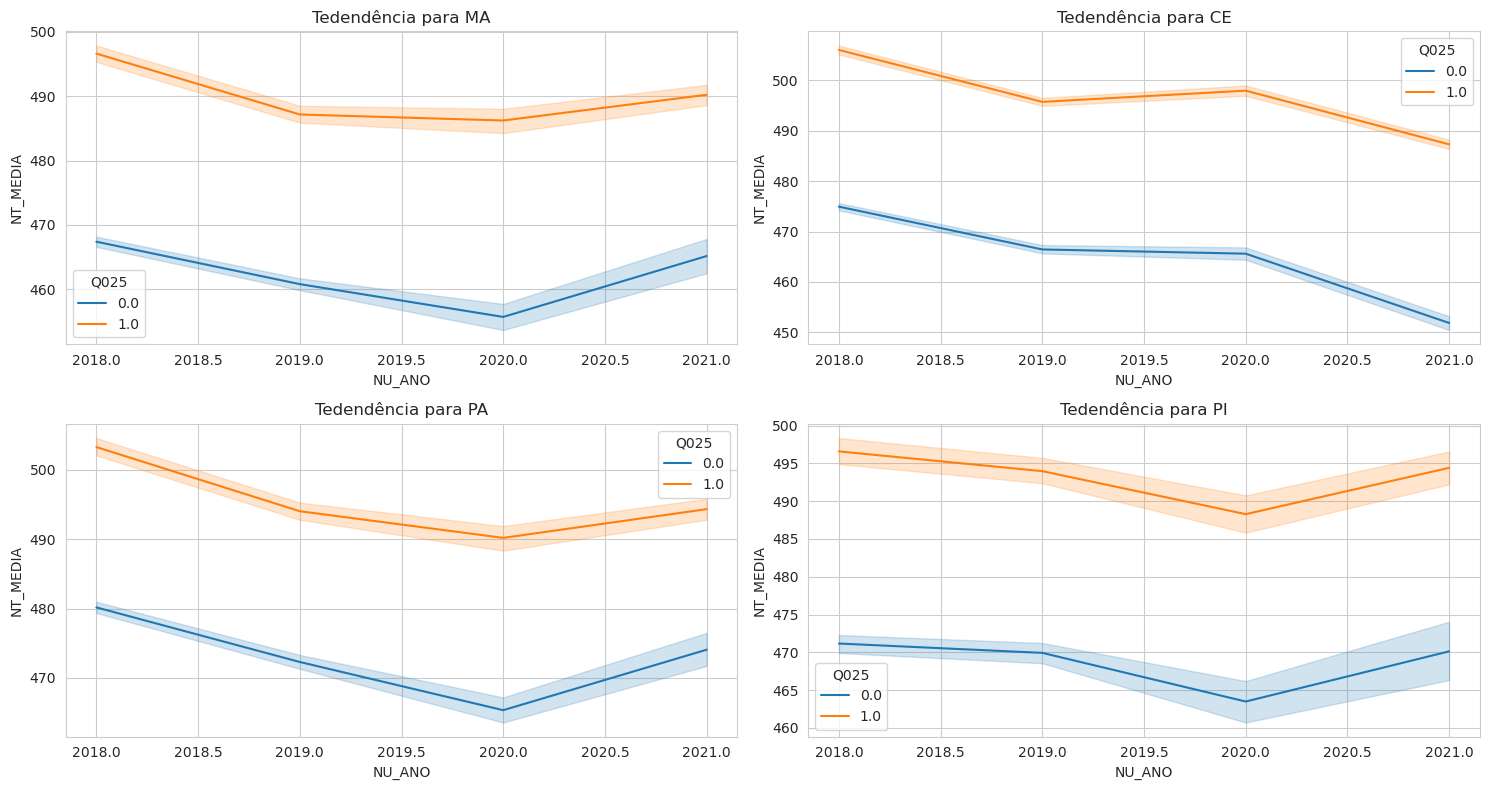

In [47]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.flatten()
tratados = ["MA","CE","PA","PI"]
sns.set_style("whitegrid")
for i, estado in enumerate(tratados):
    sel = data.query(f'SG_UF_ESC == "{estado}"').reset_index(drop=True)
    ax[i] = sns.lineplot(data=sel, x='NU_ANO', y='NT_MEDIA', hue='Q025', ax=ax[i])
    ax[i].set_title(f'Tedendência para {estado}')

plt.tight_layout()

plt.show()

### Matching

Para o processamento se assimilar ao máximo a um experimento "fully blocked", é necessário realizar o matching entre os grupos de controle e tratamento. Com isso, tenta eliminar-se vieses e desbalanceamento na análise.

#### Mahalanobis Distance Matching
$Distance(X_i, X_j) = \sqrt{(X_i - X_j)^T \Sigma^{-1} (X_i - X_j)}$

"It is like an euclidean distance, but you standarize all the variables" - Prof. Gary King

- Match each treated unit to a control unit with the smallest distance
- Control units not reused, pruned if unused
- Prune matches if Distance > caliper

Considerations: 
The standarization used in mahalanobis method is a function of the dataset, wich is not ideal. "Mahalanobis is for methodologists, in applications, use Euclidean distance" - Prof. Gary King

#### Coarsened Exact Matching
$X_i = (X_{i1}, X_{i2}, ..., X_{in})$ Covariates

$C(X_i) = coarsen(X_i)$

- Coarsen covariates
- Apply exact matching on coarsened covariates
- Prune data and apply wheigthing


### Análise para notas

In [176]:
# f = '../../Resultados/Agg/ENEM/aux/postMatching/data-municipal-*.parquet'
# data_mun = pd.concat([pd.read_parquet(f) for f in glob(f)]).reset_index(drop=True)

In [3]:
mun = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching-municipal.parquet')

In [5]:
mun.SG_UF_ESC.unique()

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [4]:
# Obtendo municípios com seus respectivos pesos
matched = pd.read_parquet('../../Resultados/Agg/ENEM/aux/postMatching/municipios-idh_NOTA.parquet', columns=['CO_MUNICIPIO_ESC','weights', 'subclass'])
# Selecionando subamostra destes municípios para dados de painel
data_mun = mun.merge(matched, on='CO_MUNICIPIO_ESC', how='inner')

In [6]:
no_ne = ['MA', 'PI', 'RN', 'CE', 'AL', 'SE', 'BA', 'RR', 'AP', 'PA', 'RO', 'AM', 'AC']

In [8]:
data_mun = mun[mun['SG_UF_ESC'].isin(no_ne)]

In [9]:
data_mun.treated.value_counts()

0    3592
1    3012
Name: treated, dtype: int64

In [11]:
sns.set_style('ticks')

In [10]:
data_mun['LOG_NT_MEDIA'] = np.log(data_mun['NT_MEDIA'])
data_mun['LOG_NT_MT'] = np.log(data_mun['NU_NOTA_MT'])
data_mun['LOG_NT_LC'] = np.log(data_mun['NU_NOTA_LC'])

/home/joao/anaconda3/envs/conectividade/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/joao/anaconda3/envs/conectividade/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/joao/anaconda3/envs/conectividade/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


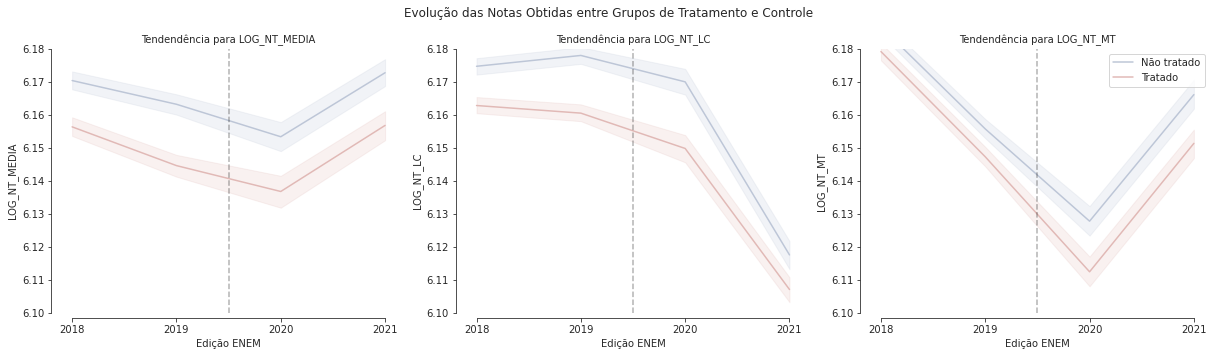

In [35]:
fig, ax = plt.subplots(1,3,figsize=(17,5))
ax = ax.flatten()
notas = ['LOG_NT_MEDIA', 'LOG_NT_LC', 'LOG_NT_MT']
sns.set_style("ticks")
for i, nota in enumerate(notas):
    sel = data_mun.copy()
    sel.treated = sel.treated.replace({0:'Não tratado', 1:'Tratado'})
    ax[i] = sns.lineplot(data=sel, x='NU_ANO', y=nota, hue='treated', palette='vlag', ax=ax[i], markers=True)
    ax[i].set_title(f'Tendendência para {nota}', fontsize=10)
    ax[i].axvline(2019.5, color='black', linestyle='--', alpha=0.3)
    ax[i].set_xticks([2018, 2019, 2020, 2021])
    ax[i].set_ylim([6.10,6.18])
    ax[i].get_legend().remove()
    ax[i].set_xlabel('Edição ENEM')

sns.despine(offset=5, trim=True)
plt.suptitle('Evolução das Notas Obtidas entre Grupos de Tratamento e Controle')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
net_x_ano = data_mun.groupby(['NU_ANO', 'treated'], as_index=False)['Q025'].mean()
net_x_ano['diff_tratado_controle']= abs(net_x_ano['Q025'].diff())

In [19]:
net_x_ano

,NU_ANO,treated,Q025,diff_tratado_controle
0,2018.0,0,0.515966,NaN
1,2018.0,1,0.318715,0.197252
2,2019.0,0,0.577612,0.258897
3,2019.0,1,0.394008,0.183604
4,2020.0,0,0.686383,0.292375
5,2020.0,1,0.526966,0.159417
6,2021.0,0,0.819782,0.292816
7,2021.0,1,0.715580,0.104202


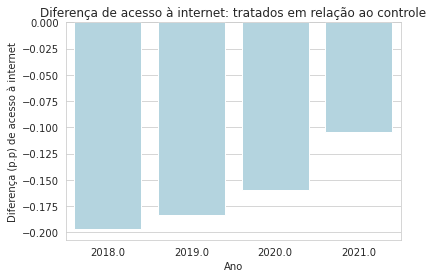

In [20]:
net_x_ano = data_mun.groupby(['NU_ANO', 'treated'], as_index=False)['Q025'].mean()
net_x_ano['diff_tratado_controle']= net_x_ano['Q025'].diff()
net_x_ano = net_x_ano[net_x_ano['treated']==1]
sns.set_style('whitegrid')
sns.barplot(data=net_x_ano, x='NU_ANO', y='diff_tratado_controle', color='lightblue')
plt.title('Diferença de acesso à internet: tratados em relação ao controle')
plt.xlabel('Ano')
plt.ylabel('Diferença (p.p) de acesso à internet')
plt.show()

In [85]:
data_mun.columns

Index(['NU_ANO', 'SG_UF_ESC', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
       'NT_MEDIA', 'LOG_NT_MEDIA', 'LOG_NT_MT', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025', 'IND_CASA',
       'NAO_BRANCO', 'MULHER', 'TP_FAIXA_ETARIA', 'SOLTEIRO', 'time',
       'treated', 'did', 'id_municipio', 'expectativa_anos_estudo',
       'taxa_analfabetismo_15_a_17', 'taxa_atraso_0_medio',
       'taxa_freq_bruta_medio', 'taxa_freq_15_17', 'indice_gini', 'idhm_e',
       'idhm_l', 'idhm_r', 'weights', 'subclass', 'LOG_NT_LC'],
      dtype='object')

In [86]:
data_mun.groupby('NU_ANO').agg({'treated':'value_counts', 'did':'value_counts'})

treated    did
NU_ANO                  
2018.0 0       52  103.0
       1       51    NaN
2019.0 0       52  103.0
       1       51    NaN
2020.0 0       52   71.0
       1       51   32.0
2021.0 0       52   52.0
       1       51   51.0

In [87]:
data_mun.weights.sum()

412.0

In [88]:
data_mun.groupby('NU_ANO')['weights'].sum()

NU_ANO
2018.0    103.0
2019.0    103.0
2020.0    103.0
2021.0    103.0
Name: weights, dtype: float64

Testando hipótese de que a política so surtiu efeito em 2021

In [21]:
data_mun.time = np.where(data_mun.NU_ANO==2021, 1, 0)
data_mun.did = data_mun.treated * data_mun.time

/home/joao/anaconda3/envs/conectividade/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
# data_mun.time = np.where(((data_mun.NU_ANO==2021) | ((data_mun.NU_ANO==2020) & (data_mun.SG_UF_ESC=='MA'))), 1, 0)
# data_mun.did = data_mun.treated * data_mun.time

In [122]:
data_mun.groupby('NU_ANO')['time'].max()

NU_ANO
2018.0    0
2019.0    0
2020.0    1
2021.0    1
Name: time, dtype: int64

In [23]:
y = data_mun['LOG_NT_MT']
x = data_mun[['time', 'treated', 'did']]
#w = data_mun['weights']

In [24]:
print('y:', y.isna().any())
print('x', x.isna().any())

y: False
x time       False
treated    False
did        False
dtype: bool


In [25]:
X = sm.add_constant(x)
wreg = sm.OLS(y, X)
wfit = wreg.fit()
print(wfit.summary())

                            OLS Regression Results                            
Dep. Variable:              LOG_NT_MT   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     28.06
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           5.06e-18
Time:                        09:35:22   Log-Likelihood:                 9347.8
No. Observations:                6604   AIC:                        -1.869e+04
Df Residuals:                    6600   BIC:                        -1.866e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1567      0.001   5437.321      0.0

In [26]:
X = sm.add_constant(x)
wreg = sm.OLS(data_mun['LOG_NT_MEDIA'], X)
wfit = wreg.fit()
print(wfit.summary())

                            OLS Regression Results                            
Dep. Variable:           LOG_NT_MEDIA   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     60.89
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           8.00e-39
Time:                        09:37:03   Log-Likelihood:                 9656.0
No. Observations:                6604   AIC:                        -1.930e+04
Df Residuals:                    6600   BIC:                        -1.928e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1623      0.001   5702.260      0.0

In [27]:
X = sm.add_constant(x)
wreg = sm.OLS(data_mun['LOG_NT_LC'], X)
wfit = wreg.fit()
print(wfit.summary())

                            OLS Regression Results                            
Dep. Variable:              LOG_NT_LC   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     556.6
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          1.73e-322
Time:                        09:37:43   Log-Likelihood:                 10574.
No. Observations:                6604   AIC:                        -2.114e+04
Df Residuals:                    6600   BIC:                        -2.111e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1742      0.001   6565.745      0.0

In [36]:
X = sm.add_constant(x)
wreg = sm.OLS(data_mun['Q025'], X)
wfit = wreg.fit()
print(wfit.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q025   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     928.5
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:44:24   Log-Likelihood:                 784.15
No. Observations:                6604   AIC:                            -1560.
Df Residuals:                    6600   BIC:                            -1533.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5933      0.004    143.272      0.0

Weighted

In [12]:
X = sm.add_constant(x)
wreg = sm.WLS(y, X, weights=w)
wfit = wreg.fit(cov_type='cluster', cov_kwds={'groups': data_mun['subclass']}) # Robust standard errors (clustered by subclass)
print(wfit.summary())

                            WLS Regression Results                            
Dep. Variable:              LOG_NT_MT   R-squared:                       0.020
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.421
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0255
Time:                        14:11:08   Log-Likelihood:                 610.69
No. Observations:                 412   AIC:                            -1213.
Df Residuals:                     408   BIC:                            -1197.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1461      0.005   1200.552      0.0

### Análise para presença de internet

In [13]:
y = data_mun['Q025']
x = data_mun[['time', 'treated', 'did']]
w = data_mun['weights']

In [14]:
X = sm.add_constant(x)
wreg = sm.WLS(y, X, weights=w)
wfit = wreg.fit(cov_type='cluster', cov_kwds={'groups': data_mun['subclass']})
print(wfit.summary())

                            WLS Regression Results                            
Dep. Variable:                   Q025   R-squared:                       0.269
Model:                            WLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     48.18
Date:                Fri, 30 Sep 2022   Prob (F-statistic):           8.34e-14
Time:                        14:12:47   Log-Likelihood:                 36.378
No. Observations:                 412   AIC:                            -64.76
Df Residuals:                     408   BIC:                            -48.67
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5648      0.029     19.403      0.0

# Plots

In [29]:
import geopandas as gpd
#from matplotlib_scalebar.scalebar import ScaleBar

In [30]:
shp = gpd.read_file('../Utils/GEO/shp/BR_Municipios_2021/BR_Municipios_2021.shp')
sh_uf = gpd.read_file('../Utils/GEO/shp/BR_UF_2021/BR_UF_2021.shp')

In [31]:
mapa = shp.merge(data_mun, left_on='CD_MUN', right_on='CO_MUNICIPIO_ESC')
mapa.treated.replace({0:'Controle', 1:'Tratamento'}, inplace=True)

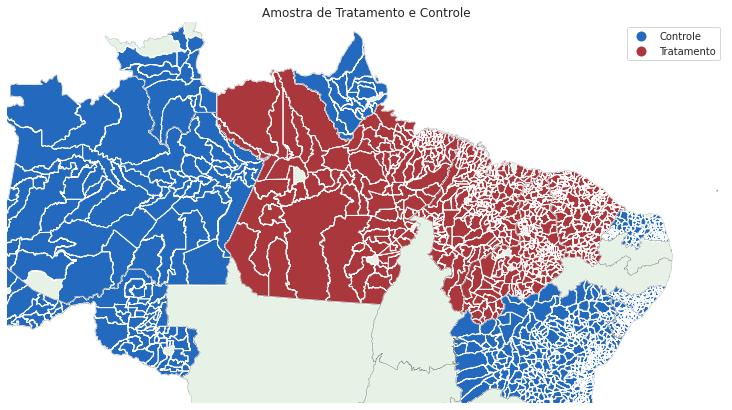

In [32]:
fig, ax = plt.subplots(1, figsize=(18, 7))

sh_uf.boundary.plot(linewidth=.2, color='black', zorder=2, alpha=0.5, ax=ax)
sh_uf.plot(color='g', ax=ax, alpha=0.1)
mapa.plot(column='treated', categorical=True, legend=True, ax=ax, cmap='vlag')
ax.set_ylim([-15, 5])
ax.set_xlim([-70, -32])
ax.axis('off')
#ax.add_artist(ScaleBar(1, location='lower left'))
plt.title('Amostra de Tratamento e Controle')

plt.show()